#  SIGN Recognition using Convolutional Neural Networks

In [19]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
#from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)
tf.set_random_seed(1)

In [20]:
# Loading the data
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


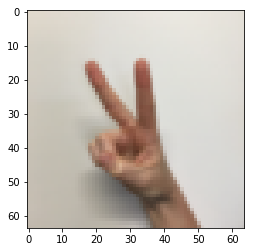

In [21]:
# Sample Image
index = 4
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [22]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [23]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

In [24]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 6), dtype=float32)


In [25]:
def initialize_parameters():
    """
    W1 : [4, 4, 3, 8]
    W2 : [2, 2, 8, 16]
    """            
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}

    return parameters

In [26]:
tf.reset_default_graph()

with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


### Forward propagation
`CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: (8, 8) filter size and (8, 8) stride with padding "SAME"
     - Conv2D: stride 1 with padding "SAME"
     - ReLU
     - Max pool: (4,4) filter size and (4,4) stride with padding "SAME"
     - Flatten
     - FULLYCONNECTED (FC) layer

In [27]:
def forward_propagation(X, parameters):
    # Get Parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    # CONV2D
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    # FLATTEN
    P = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED
    Z3 = tf.contrib.layers.fully_connected(P, 6, activation_fn=None)

    return Z3

In [28]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[-0.44670227 -1.5720876  -1.5304923  -2.3101304  -1.2910438   0.46852064]
 [-0.17601591 -1.5797201  -1.4737016  -2.616721   -1.0081065   0.5747785 ]]


In [29]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    return cost

In [30]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 2.9103396


In [34]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=200, minibatch_size=64, print_cost=True):
    
    ops.reset_default_graph()                      
    tf.set_random_seed(1)                          
    seed = 3                                       
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                              
    
    # Create Placeholders 
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    
    # Compute Cost
    cost = compute_cost(Z3, Y)
    
    # Backpropagation
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    

    init = tf.global_variables_initializer()     
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # Plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        plt.savefig("cost_vs_iter.png")
        
        # Calculate accuracy on the test set
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.917929
Cost after epoch 5: 1.506757
Cost after epoch 10: 0.955359
Cost after epoch 15: 0.845802
Cost after epoch 20: 0.701173
Cost after epoch 25: 0.570725
Cost after epoch 30: 0.531806
Cost after epoch 35: 0.522357
Cost after epoch 40: 0.426237
Cost after epoch 45: 0.416917
Cost after epoch 50: 0.392239
Cost after epoch 55: 0.351203
Cost after epoch 60: 0.300881
Cost after epoch 65: 0.299140
Cost after epoch 70: 0.319066
Cost after epoch 75: 0.292510
Cost after epoch 80: 0.270511
Cost after epoch 85: 0.298058
Cost after epoch 90: 0.211864
Cost after epoch 95: 0.164706
Cost after epoch 100: 0.193072
Cost after epoch 105: 0.185725
Cost after epoch 110: 0.161494
Cost after epoch 115: 0.158245
Cost after epoch 120: 0.151666
Cost after epoch 125: 0.218219
Cost after epoch 130: 0.122887
Cost after epoch 135: 0.121649
Cost after epoch 140: 0.109068
Cost after epoch 145: 0.094107
Cost after epoch 150: 0.131714
Cost after epoch 155: 0.111234
Cost after epoch 160: 0.112321

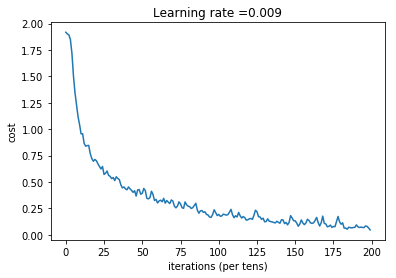

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9898148
Test Accuracy: 0.81666666


In [32]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [33]:
#fname = "images/test_thumbsup.jpg"
#image = np.array(ndimage.imread(fname, flatten=False))
#my_image = scipy.misc.imresize(image, size=(64,64))
#plt.imshow(my_image)
tf.__version__

'1.2.1'